# ECE 570 Assignment 7 Exercise






Your Name: Souradip Pal

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build an autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [1]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################
  def __init__(self, mu = 0.0, sigma=0.1):
    self.mu = mu
    self.sigma = sigma
      
  def __call__(self, tensor):
    tensor += torch.randn(tensor.size()) * self.sigma + self.mu
    tensor = torch.clip(tensor, 0., 1.)
    return tensor
  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

1.0
0.0


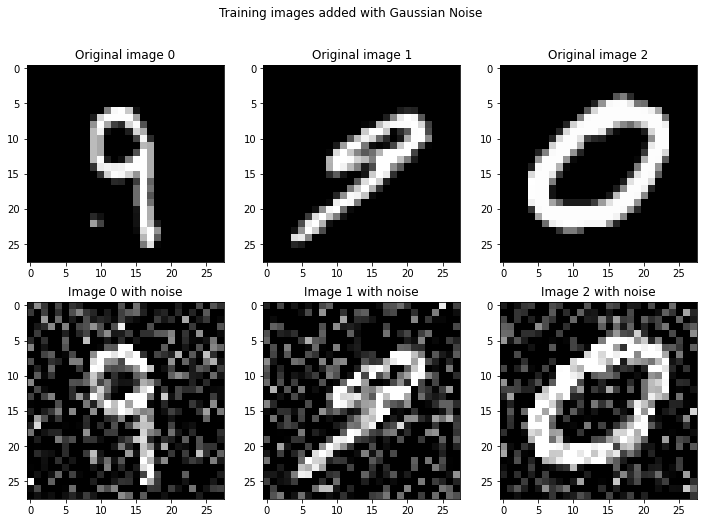

In [2]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
_, (noisy, original) = next(enumerate(train_loader))

fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(original[idx][0], cmap='gray')
  ax[0,idx].set_title(f'Original image {idx}')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
  ax[1,idx].set_title(f'Image {idx} with noise')
fig.suptitle('Training images added with Gaussian Noise')
fig.show()
#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is more complicated (more params, different layers, combination of CNNs/FCs) than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU.
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [3]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

n_channels = 1
n_latent = 16
latent_features = 8

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

class CustomDenoisingAutoEncoder(nn.Module):
  def __init__(self):
    super(CustomDenoisingAutoEncoder, self).__init__()

    # encoder
    self.en_conv1 = nn.Conv2d(n_channels, 8, kernel_size=3, stride=2, padding=1)
    self.en_bc = nn.BatchNorm2d(8)
    self.en_conv2 = nn.Conv2d(8, n_latent, kernel_size=3, stride=2, padding=1)
    self.en_fc1 = nn.Linear(in_features=784, out_features=128)
    self.en_fc2 = nn.Linear(in_features=128, out_features=latent_features)

    # decoder
    self.de_tran_conv1 = nn.ConvTranspose2d(8, n_channels, kernel_size=3, stride=2, padding=1,output_padding=1)
    self.de_tran_conv2 = nn.ConvTranspose2d(n_latent, 8, kernel_size=3, stride=2, padding=1,output_padding=1)
    self.de_bc = nn.BatchNorm2d(8)
    self.de_fc1 = nn.Linear(in_features=latent_features, out_features=128)
    self.de_fc2 = nn.Linear(in_features=128, out_features=784)

  def forward(self, x):

    # encoding layers
    x = self.en_conv1(x)
    x = F.relu(self.en_bc(x))
    x = self.en_conv2(x)
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = self.en_fc2(x)

    # decoding layers
    x = F.relu(self.de_fc1(x))
    x = F.relu(self.de_fc2(x))
    x = x.view(-1, n_latent, 7, 7)
    x = self.de_tran_conv2(x)
    x = F.relu(self.de_bc(x))
    x = self.de_tran_conv1(x)
    x = torch.sigmoid(x)
    return x


AE = CustomDenoisingAutoEncoder().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-3)
loss_fn = nn.MSELoss(reduction='sum')

#########################  <END YOUR CODE>  ############################

In [4]:
###########################   <YOUR CODE>  ############################
def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (nosiy_images, original_images) in enumerate(train_loader):
    optimizer.zero_grad()
    nosiy_images = nosiy_images.to(device)
    original_images = original_images.to(device)
    output = AE(nosiy_images)
    loss = loss_fn(output, original_images)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train)
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(nosiy_images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for noisy_images, original_images in test_loader:
      noisy_images = noisy_images.to(device)
      original_images = original_images.to(device)
      output = AE(noisy_images)
      test_loss += loss_fn(output, original_images).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

#########################  <END YOUR CODE>  ############################

In [5]:
###########################   <YOUR CODE>  ############################
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 5

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)
  
#########################  <END YOUR CODE>  ############################

Epoch 1: [0/60000] Loss: 153.8064727783203
Epoch 1: [6400/60000] Loss: 67.85018920898438
Epoch 1: [12800/60000] Loss: 41.056427001953125
Epoch 1: [19200/60000] Loss: 30.91881561279297
Epoch 1: [25600/60000] Loss: 26.195444107055664
Epoch 1: [32000/60000] Loss: 22.04198455810547
Epoch 1: [38400/60000] Loss: 22.09329605102539
Epoch 1: [44800/60000] Loss: 19.044124603271484
Epoch 1: [51200/60000] Loss: 20.98859405517578
Epoch 1: [57600/60000] Loss: 18.95020294189453
Test result on epoch 1: Avg loss is 19.1708046875
Epoch 2: [0/60000] Loss: 20.99726104736328
Epoch 2: [6400/60000] Loss: 18.07321548461914
Epoch 2: [12800/60000] Loss: 17.993694305419922
Epoch 2: [19200/60000] Loss: 18.888545989990234
Epoch 2: [25600/60000] Loss: 18.837692260742188
Epoch 2: [32000/60000] Loss: 16.435474395751953
Epoch 2: [38400/60000] Loss: 18.477031707763672
Epoch 2: [44800/60000] Loss: 18.347583770751953
Epoch 2: [51200/60000] Loss: 18.121530532836914
Epoch 2: [57600/60000] Loss: 17.022266387939453
Test resu

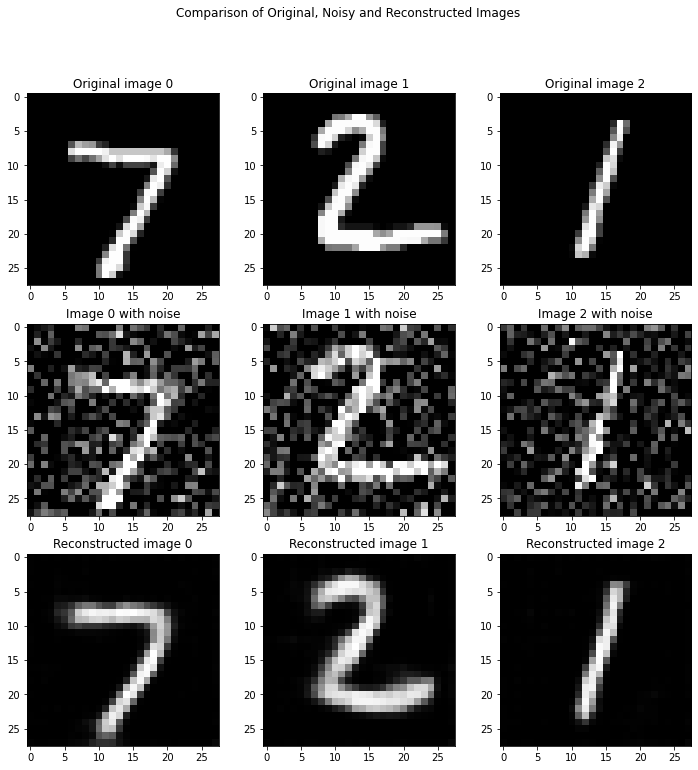

In [6]:
###########################   <YOUR CODE>  ############################
_, (noisy, original) = next(enumerate(test_loader))

AE.eval() # we need to set the mode for our model
with torch.no_grad():
    noisy = noisy.to(device)
    output = AE(noisy)

noisy = noisy.cpu().detach()
output = output.cpu().detach()

fig,ax = plt.subplots(3,3)
fig.set_size_inches(12,12)
for idx in range(3):
  ax[0,idx].imshow(original[idx][0], cmap='gray')
  ax[0,idx].set_title(f'Original image {idx}')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
  ax[1,idx].set_title(f'Image {idx} with noise')
  ax[2,idx].imshow(output[idx][0], cmap='gray')
  ax[2,idx].set_title(f'Reconstructed image {idx}')
fig.suptitle('Comparison of Original, Noisy and Reconstructed Images')
fig.show()
#########################  <END YOUR CODE>  ############################

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [7]:
###########################   <YOUR CODE>  ############################
import torchvision
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms)

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
#########################  <END YOUR CODE>  ############################
print(f'We are using device name "{device}"')

We are using device name "cuda"


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html#torch.nn.functional.binary_cross_entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. (You can find the proof in the paper mentioned above).


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [8]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
  rec_loss = F.binary_cross_entropy(output, images, reduction = 'sum')
  kl_loss = -0.5*torch.sum(1+log_var - mu**2.0 - torch.exp(log_var))
  return rec_loss, kl_loss 
  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [9]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################
    # define the transformations for your encoder and decoder
        
    # encoder
    self.enc1 = nn.Linear(in_features=784, out_features=512)
    self.enc2 = nn.Linear(in_features=512, out_features=self.latent_feature*2)

    # decoder
    self.dec1 = nn.Linear(in_features=self.latent_feature, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=784)
    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################
    sigma = torch.exp(0.5*log_var)
    N = torch.distributions.Normal(mu, sigma)
    sample = N.rsample()
    #########################  <END YOUR CODE>  ############################
    return sample
    
  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <YOUR CODE>  ############################
    x = x.view(-1, 784)
    x = F.relu(self.enc1(x))
    x = self.enc2(x)
    x = x.view(-1, 2, self.latent_feature)
    mu = x[:, 0, :]
    log_var = x[:, 1, :] 
    z = self.reparameterize(mu, log_var)
    #########################  <END YOUR CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################
    x = F.relu(self.dec1(z))
    x = torch.sigmoid(self.dec2(x))
    x = x.view(-1, 1, 28 ,28)
        
    #########################  <END YOUR CODE>  ###########################
    return x


  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """
    # encoding layers


    ###########################   <YOUR CODE>  ############################
    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)
    #########################  <END YOUR CODE>  ###########################

    
    return x, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, title, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

In [10]:
###########################   <YOUR CODE>  ############################
VAE = our_VAE().to(device)
optimizer = optim.Adam(VAE.parameters(), lr=1e-3)

def train(epoch, model, optimizer, device):

  model.train() # we need to set the mode for our model

  for batch_idx, (images, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    images = images.to(device)
    output, mu, log_var = model(images)
    rec_loss, kl_loss = vae_loss(output, mu, log_var, images) 
    loss = rec_loss + kl_loss
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_rec_losses.append(rec_loss.item()/batch_size_train)
      train_kl_losses.append(kl_loss.item()/batch_size_train)
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, model, device):

  model.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for (images, labels) in test_loader:
      images = images.to(device)
      output, mu, log_var = model(images)
      rec_loss, kl_loss = vae_loss(output, mu, log_var, images)
      test_loss += rec_loss + kl_loss
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')
#########################  <END YOUR CODE>  ###########################


In [11]:
###########################   <YOUR CODE>  ############################
train_losses = []
train_rec_losses = []
train_kl_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 5

for epoch in range(1, max_epoch+1):
  train(epoch, VAE, optimizer, device=device)
  test(epoch, VAE, device=device)
#########################  <END YOUR CODE>  ###########################


Epoch 1: [0/60000] Loss: 546.522705078125
Epoch 1: [6400/60000] Loss: 164.29710388183594
Epoch 1: [12800/60000] Loss: 152.59933471679688
Epoch 1: [19200/60000] Loss: 139.8684844970703
Epoch 1: [25600/60000] Loss: 128.42987060546875
Epoch 1: [32000/60000] Loss: 125.70735168457031
Epoch 1: [38400/60000] Loss: 121.91995239257812
Epoch 1: [44800/60000] Loss: 129.31451416015625
Epoch 1: [51200/60000] Loss: 118.73540496826172
Epoch 1: [57600/60000] Loss: 119.63568115234375
Test result on epoch 1: Avg loss is 116.92914581298828
Epoch 2: [0/60000] Loss: 116.36129760742188
Epoch 2: [6400/60000] Loss: 122.18041229248047
Epoch 2: [12800/60000] Loss: 116.27860260009766
Epoch 2: [19200/60000] Loss: 111.56669616699219
Epoch 2: [25600/60000] Loss: 110.40467834472656
Epoch 2: [32000/60000] Loss: 116.56016540527344
Epoch 2: [38400/60000] Loss: 110.608154296875
Epoch 2: [44800/60000] Loss: 107.15911865234375
Epoch 2: [51200/60000] Loss: 111.8387222290039
Epoch 2: [57600/60000] Loss: 111.44779968261719
T

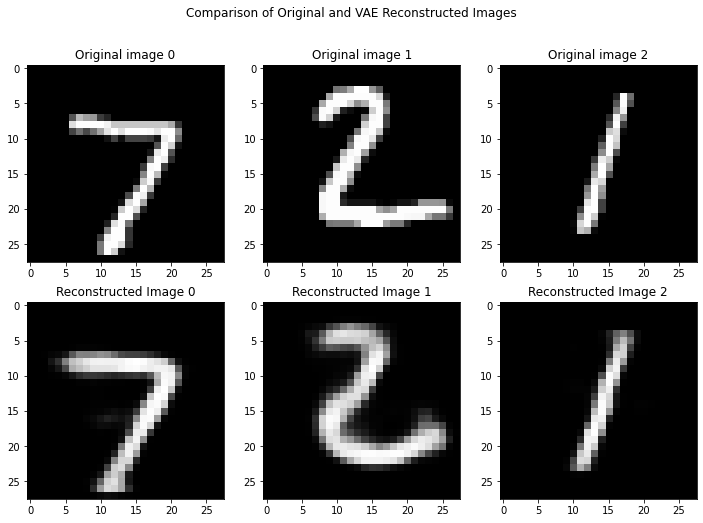

In [12]:
###########################   <YOUR CODE>  ############################
_, (images, labels) = next(enumerate(test_loader))

VAE.eval() # we need to set the mode for our model
with torch.no_grad():
    images = images.to(device)
    output, mu, log_var = VAE(images)

images = images.cpu().detach()
output = output.cpu().detach()

fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[0,idx].set_title(f'Original image {idx}')
  ax[1,idx].imshow(output[idx][0], cmap='gray')
  ax[1,idx].set_title(f'Reconstructed Image {idx}')
fig.suptitle('Comparison of Original and VAE Reconstructed Images')
fig.show()
#########################  <END YOUR CODE>  ###########################


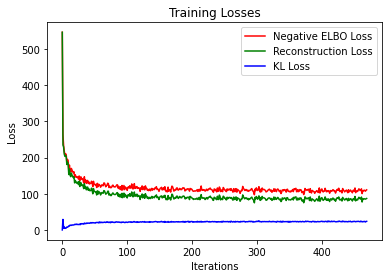

In [13]:
###########################   <YOUR CODE>  ############################
plt.plot(train_losses, 'r', label = 'Negative ELBO Loss')
plt.plot(train_rec_losses, 'g', label = 'Reconstruction Loss')
plt.plot(train_kl_losses, 'b', label = 'KL Loss')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.show()
#########################  <END YOUR CODE>  ###########################


# Exercise 3 (optional, ungraded): Exploring the latent space of VAE

### Task 1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task. With  correct training you will see some clusters in the latent space after some epochs.


In [14]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

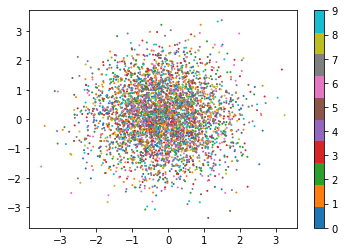

In [15]:
###########################   <YOUR CODE>  ############################
VAE2 = our_VAE(latent_feature=2).to(device)
optimizer = optim.Adam(VAE2.parameters(), lr=1e-4)

plot_latent(VAE2.to('cpu'), test_loader, num_batches=2)
#########################  <END YOUR CODE>  ###########################

Epoch 1: [0/60000] Loss: 551.3355102539062
Epoch 1: [6400/60000] Loss: 240.07730102539062
Epoch 1: [12800/60000] Loss: 233.14779663085938
Epoch 1: [19200/60000] Loss: 213.99807739257812
Epoch 1: [25600/60000] Loss: 198.898681640625
Epoch 1: [32000/60000] Loss: 200.97561645507812
Epoch 1: [38400/60000] Loss: 202.83242797851562
Epoch 1: [44800/60000] Loss: 195.30972290039062
Epoch 1: [51200/60000] Loss: 186.98826599121094
Epoch 1: [57600/60000] Loss: 188.8445587158203
Test result on epoch 1: Avg loss is 187.9190673828125


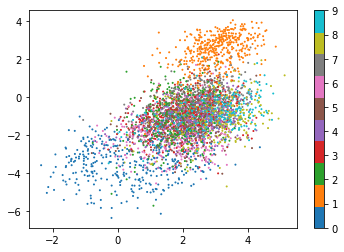

Epoch 2: [0/60000] Loss: 191.0154571533203
Epoch 2: [6400/60000] Loss: 186.04095458984375
Epoch 2: [12800/60000] Loss: 188.52947998046875
Epoch 2: [19200/60000] Loss: 191.89483642578125
Epoch 2: [25600/60000] Loss: 175.19207763671875
Epoch 2: [32000/60000] Loss: 179.163818359375
Epoch 2: [38400/60000] Loss: 188.5378875732422
Epoch 2: [44800/60000] Loss: 185.21543884277344
Epoch 2: [51200/60000] Loss: 172.6783447265625
Epoch 2: [57600/60000] Loss: 180.56336975097656
Test result on epoch 2: Avg loss is 179.0623779296875


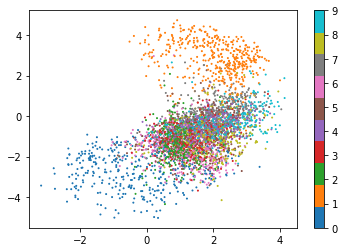

Epoch 3: [0/60000] Loss: 182.60585021972656
Epoch 3: [6400/60000] Loss: 179.2914581298828
Epoch 3: [12800/60000] Loss: 178.51968383789062
Epoch 3: [19200/60000] Loss: 167.31576538085938
Epoch 3: [25600/60000] Loss: 169.10658264160156
Epoch 3: [32000/60000] Loss: 185.65516662597656
Epoch 3: [38400/60000] Loss: 174.60781860351562
Epoch 3: [44800/60000] Loss: 176.08155822753906
Epoch 3: [51200/60000] Loss: 173.6144561767578
Epoch 3: [57600/60000] Loss: 176.49160766601562
Test result on epoch 3: Avg loss is 173.40480041503906


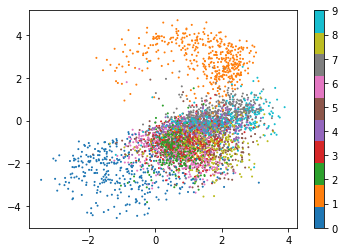

In [16]:
###########################   <YOUR CODE>  ############################
train_losses = []
train_rec_losses = []
train_kl_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

for epoch in range(1, max_epoch+1):
  train(epoch, VAE2.to(device), optimizer, device=device)
  test(epoch, VAE2.to(device), device=device)
  plot_latent(VAE2.to('cpu'), test_loader, num_batches=2)
#########################  <END YOUR CODE>  ###########################


### Task 2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model (model with 2 latent features) and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

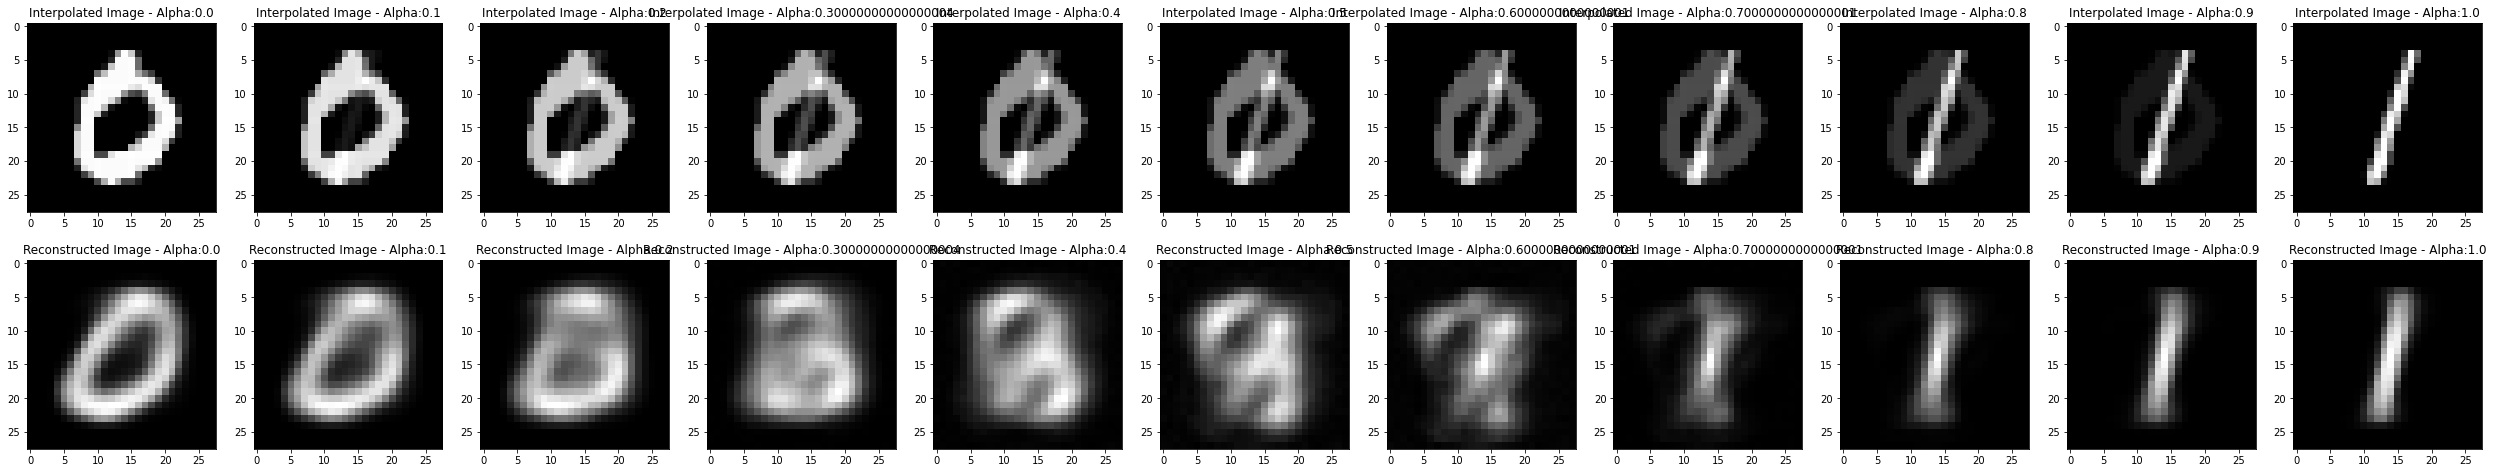

In [17]:
###########################   <YOUR CODE>  ############################
_, (images, labels) = next(enumerate(test_loader))

x0 = images[labels == 0][0]
x1 = images[labels == 1][0]

VAE2 = VAE2.to(device)

_,_,z0 = VAE2.encoder(x0.to(device))
_,_,z1 = VAE2.encoder(x1.to(device))

fig,ax = plt.subplots(2,11)
fig.set_size_inches(44,8)
for idx, alpha in enumerate(np.linspace(0, 1, 11)):
    xp = alpha*x1 + (1 - alpha)*x0
    zp = alpha*z1 + (1 - alpha)*z0

    xp_dec = VAE2.decoder(zp.to(device))
    xp_dec = xp_dec.to('cpu').detach().numpy()
    
    ax[0,idx].imshow(xp[0], cmap='gray')
    ax[0,idx].set_title(f'Interpolated Image - Alpha:{alpha}')
    ax[1,idx].imshow(xp_dec[0][0], cmap='gray')
    ax[1,idx].set_title(f'Reconstructed Image - Alpha:{alpha}')

fig.show()
#########################  <END YOUR CODE>  ###########################